# 1) Making Imports and Downloading thee Price Data

In [9]:
from Historic_Crypto import HistoricalData
import pandas as pd 
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import matplotlib.colors as col 
from matplotlib import cm
import numpy as np 

# the price frequency in seconds: 21600 = 6 hour price data, 86400 = daily price data
frequency = 21600
# The beginning of the period for which prices will be retrieved
from_date = '2017-01-01-00-00'
# The currency price pairs for which the data will be retrieved
coinlist = ['ETH-USD', 'BTC-USD']

# Query the data
for i in range(len(coinlist)):
    coinname = coinlist[i]
    pricedata = HistoricalData(coinname, frequency, from_date).retrieve_data()
    pricedf = pricedata[['close', 'low', 'high']]
    if i == 0:
        df = pd.DataFrame(pricedf.copy())
    else:
        df = pd.merge(left=df, right=pricedf, how='left', left_index=True, right_index=True)   
    df.rename(columns={"close": "close-" + coinname}, inplace=True)
    df.rename(columns={"low": "low-" + coinname}, inplace=True)
    df.rename(columns={"high": "high-" + coinname}, inplace=True)
df.head()

Checking input parameters are in the correct format...
Formatting Dates...
Checking if ticker supplied is available on the CoinBase Pro API...
Connected to the CoinBase Pro API...
Ticker 'ETH-USD' found at the CoinBase Pro API, continuing to extraction...
Data for chunk 0 of 19 extracted
Data for chunk 1 of 19 extracted
Data for chunk 2 of 19 extracted
Data for chunk 3 of 19 extracted
Data for chunk 4 of 19 extracted
Data for chunk 5 of 19 extracted
Data for chunk 6 of 19 extracted
Data for chunk 7 of 19 extracted
Data for chunk 8 of 19 extracted
Data for chunk 9 of 19 extracted
Data for chunk 10 of 19 extracted
Data for chunk 11 of 19 extracted
Data for chunk 12 of 19 extracted
Data for chunk 13 of 19 extracted
Data for chunk 14 of 19 extracted
Data for chunk 15 of 19 extracted
Data for chunk 16 of 19 extracted
Data for chunk 17 of 19 extracted
Data for chunk 18 of 19 extracted
Data for chunk 19 of 19 extracted
Checking input parameters are in the correct format...
Formatting Dates...

,close-ETH-USD,low-ETH-USD,high-ETH-USD,close-BTC-USD,low-BTC-USD,high-BTC-USD
time,,,,,,
2017-01-01 06:00:00,8.23,8.16,8.49,975.00,964.54,975.00
2017-01-01 12:00:00,8.33,8.20,8.44,994.42,974.01,994.97
2017-01-01 18:00:00,8.18,8.08,8.37,992.95,986.86,1000.00
2017-01-02 00:00:00,8.13,8.05,8.22,1003.64,990.52,1012.00
2017-01-02 06:00:00,8.10,8.09,8.20,1024.84,1002.92,1024.95


(0, 1431.97)

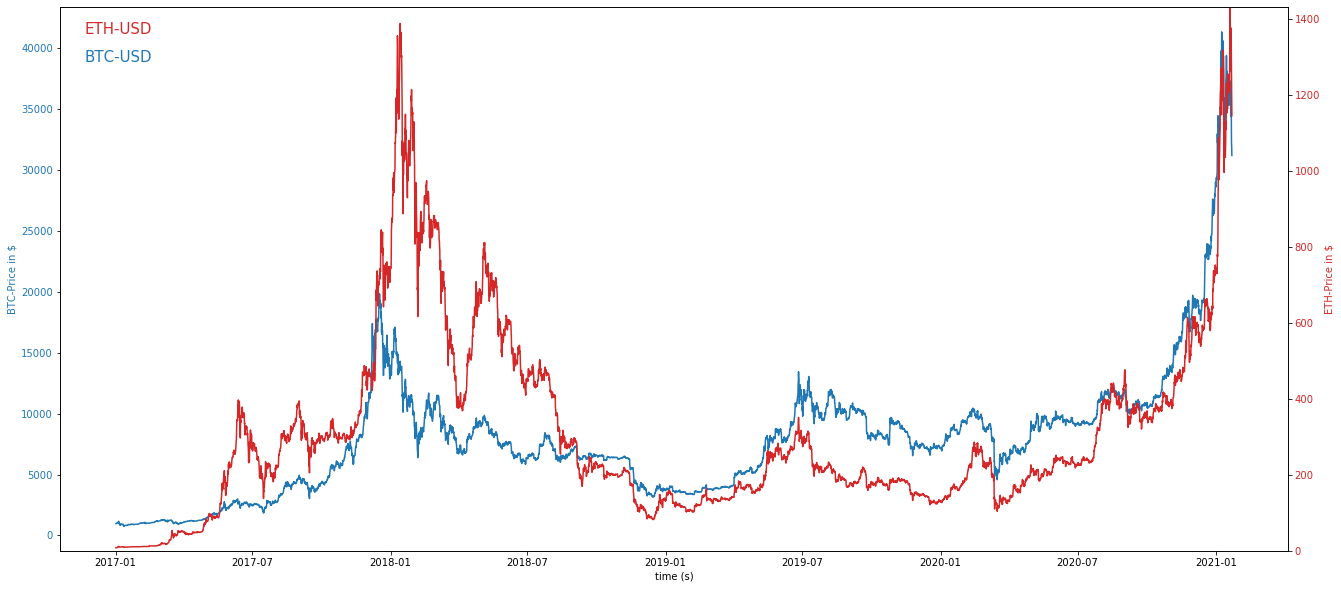

In [10]:
# Create a Price Chart on BTC and ETH
x = df.index
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=False)

# BTC-USD
color = 'tab:blue'
y = df['close-BTC-USD']
ax1.set_xlabel('time (s)')
ax1.set_ylabel('BTC-Price in $', color=color)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.text(0.02, 0.9, 'BTC-USD',  transform=ax1.transAxes, color=color, fontsize=15)

# ETH-USD
y = df['close-ETH-USD']
color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('ETH-Price in $', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.text(0.02, 0.95, 'ETH-USD',  transform=ax2.transAxes, color=color, fontsize=15)
ax2.set_ylim(0, y.max())

# 2) Calculation of KPIs

In [4]:
def add_measures(df):
    # Calculate the 50 day Pearson Correlation 
    cor_period = 30 #this corresponds to a monthly correlation period
    columntobeadded = [0] * cor_period
    df = df.fillna(0) 
    for i in range(len(df)-cor_period):
        btc = df['close-BTC-USD'][i:i+cor_period]
        eth = df['close-ETH-USD'][i:i+cor_period]
        corr, _ = pearsonr(btc, eth)
        columntobeadded.append(corr)    
    # insert the colours into our original dataframe    
    df.insert(2, "P_Correlation", columntobeadded, True)

    # Calculate the RSI
    # Moving Averages on high, lows, and std - different periods
    df['MA200_low'] = df['low-BTC-USD'].rolling(window=200).min()
    df['MA14_low'] = df['low-BTC-USD'].rolling(window=14).min()
    df['MA200_high'] = df['high-BTC-USD'].rolling(window=200).max()
    df['MA14_high'] = df['high-BTC-USD'].rolling(window=14).max()

    # Relative Strength Index (RSI)
    df['K-ratio'] = 100*((df['close-BTC-USD'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean() 

    # Replace nas 
    #nareplace = df.at[df.index.max(), 'close-BTC-USD']    
    df.fillna(0, inplace=True)    
    return df
    
dfcr = add_measures(df)
dfcr.head()

,close-ETH-USD,low-ETH-USD,P_Correlation,high-ETH-USD,close-BTC-USD,low-BTC-USD,high-BTC-USD,MA200_low,MA14_low,MA200_high,MA14_high,K-ratio,RSI
time,,,,,,,,,,,,,
2017-01-02,8.38,8.05,0.0,8.53,1011.45,990.52,1034.39,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,9.59,8.24,0.0,10.02,1020.67,1006.71,1036.99,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,11.17,9.34,0.0,11.17,1130.30,1018.00,1147.00,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,10.23,9.08,0.0,11.80,1007.00,880.00,1175.00,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-06,10.14,9.52,0.0,10.46,895.71,875.01,1033.85,0.0,0.0,0.0,0.0,0.0,0.0


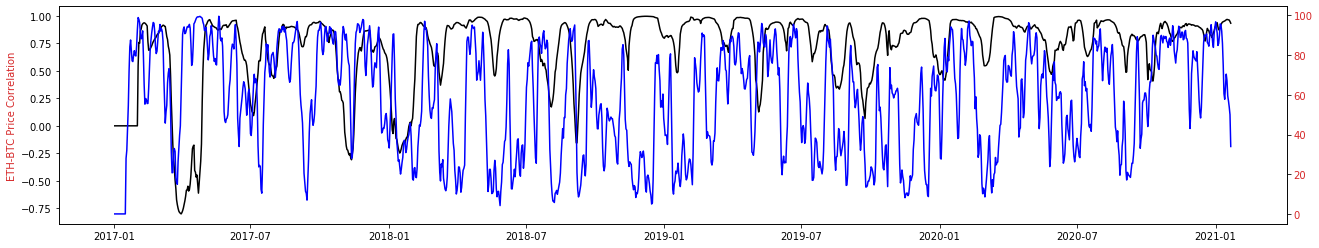

In [5]:
# Visualize measures

fig, ax1 = plt.subplots(figsize=(22, 4), sharex=False)
plt.ylabel('ETH-BTC Price Correlation', color=color)  # we already handled the x-label with ax1
x = y = dfcr.index
ax1.plot(x, dfcr['P_Correlation'], color='black')
ax2 = ax1.twinx()
ax2.plot(x, dfcr['RSI'], color='blue')
plt.tick_params(axis='y', labelcolor=color)

plt.show()

# 3) Bitcoin Price Chart colored by RSI

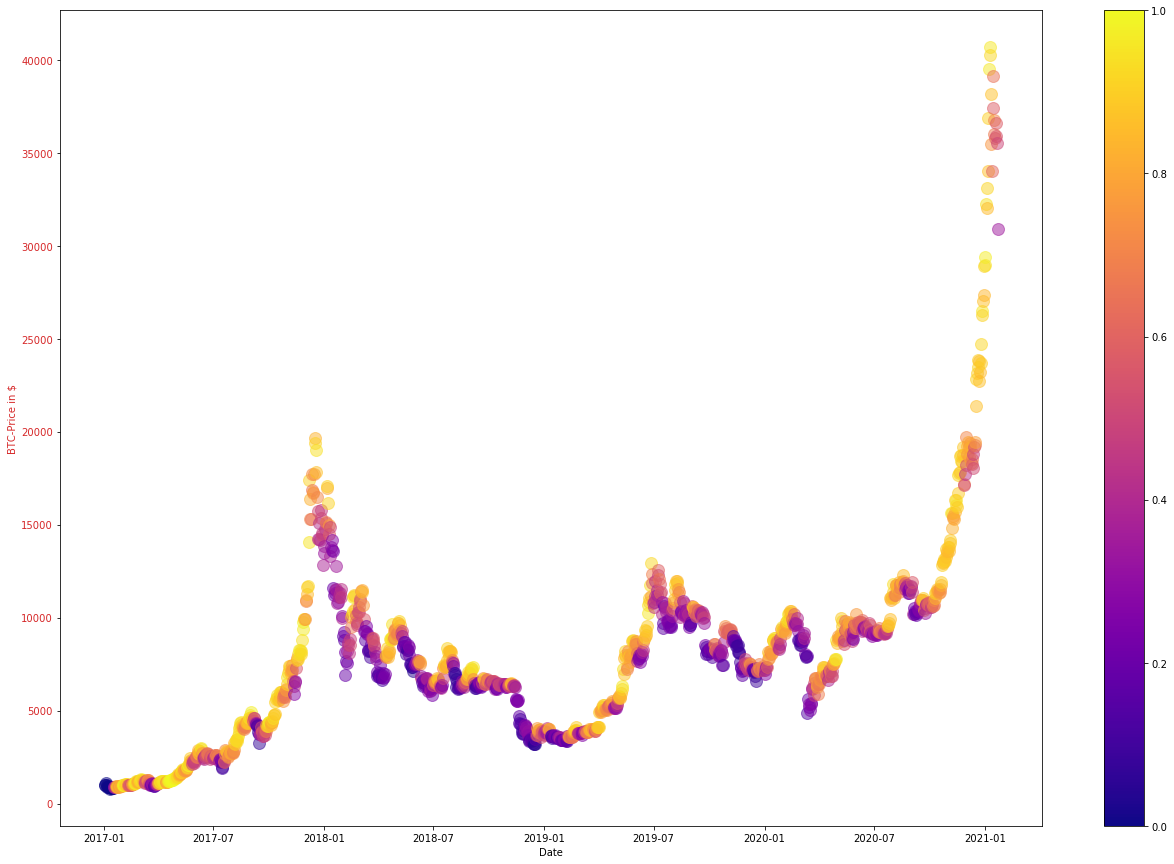

In [7]:
# generate a list of colors and add it to our dataframe
s = col.Normalize(vmin=-1.,vmax=1.)

def get_colors(ind):
    colormap = plt.get_cmap('plasma')
    colorlist = []
    norm = col.Normalize(vmin=ind.min(), vmax=ind.max())
    for i in ind:
        #print(list(colormap(norm(i))))
        colorlist.append(list(colormap(norm(i))))
    return colorlist
                         
y = np.array(dfcr['RSI'])
dfcr['cor_colors'] = get_colors(y)

# Create a Price Chart
pd.plotting.register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(22, 15), sharex=False)
x = dfcr.index
y = dfcr['close-BTC-USD']
z = dfcr['cor_colors']

# draw points
for i in range(len(dfcr)):
    ax1.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.5, markersize=12)
ax1.set_ylabel('BTC-Price in $', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Date')

# plot the color bar
pos_neg_clipped = ax2.imshow(list(z), cmap='plasma', vmin=1, vmax=0, interpolation='none')
cb = plt.colorbar(pos_neg_clipped)

# 4) Bitcoin Price Chart colored by ETH-correlation

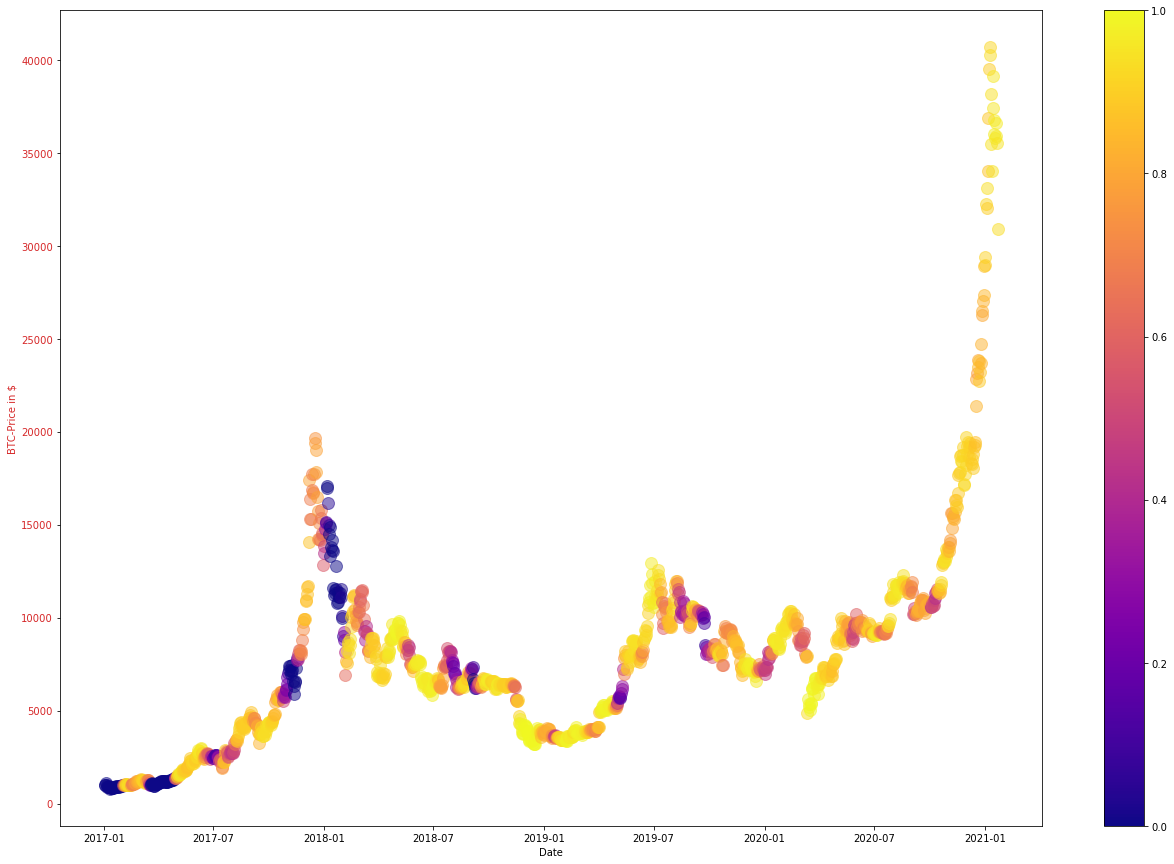

In [8]:
# generate a list of colors and add it to our dataframe
colormap = plt.get_cmap('plasma')
colorlist = []
s = np.array(dfcr['P_Correlation'])

for i in s:
    colorlist.append(colormap(i))
dfcr['cor_colors'] = colorlist

# create a price chart
pd.plotting.register_matplotlib_converters()
fig, ax1 = plt.subplots(figsize=(22, 15), sharex=False)
x = dfcr.index
y = dfcr['close-BTC-USD']
z = dfcr['cor_colors']

# draw points
for i in range(len(dfcr)):
    ax1.plot(x[i], np.array(y[i]), 'o',  color=z[i], alpha = 0.5, markersize=12)
ax1.set_ylabel('BTC-Price in $', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Date')

# plot the color bar
pos_neg_clipped = ax2.imshow(list(z), cmap='plasma', vmin=0, vmax=1, interpolation='none')
cb = plt.colorbar(pos_neg_clipped)